## Use Case Title: Support policy on identifying and quantifying ozone recovery 
## User Question: How well does the dataset represent the ozone layer variability over time?

## Take-home messages
- The MERGED-UV v2000 provides a long-term, consistent record of total column ozone concentration and is therefore valuable for providing insight into the evolution of the ozone layer, although data prior to 2004 should be carefully evaluated.

- The MERGED-UV v2000 does not include measurements during the polar night at latitudes higher than 57.5° in both hemispheres and therefore cannot be used to describe the ozone climatology in these regions.
  
- The lack of data in high-latitude regions during the polar night hinders the use of the MERGED-UV v2000 dataset to monitor the evolution of alarming ozone depletion at the poles.

- The lack of data during the polar nights at high latitudes is also a limitation for the quantitative assessment of ozone averages and trends at the global scale.

- Despite the data gaps, the MERGED-UV v2000 dataset is able to detect the major ozone variations over time described in the literature. 

## Introduction

Assessing the return of the ozone layer to historical levels and the full recovery from ozone-depleting substances (ODS) under the 1987 Montreal Protocol is a critical issue. The Montreal Protocol required the international scientific community to provide governments with regular updates on the latest scientific knowledge about the ozone layer. Since 1987, ten reports called "Scientific Assessment of Ozone Depletion" have been produced. These regular assessments have guided policymakers in strengthening the provisions of the Montreal Protocol. The World Meteorological Organization (WMO) reports make extensive use of satellite products.

In this application, we evaluate the ability of the MERGED-UV dataset version v2000 to describe the total column ozone (TCO) variability over time and capture known changes in the ozone layer.

The v2000 MERGED-UV dataset is included in the monthly gridded ozone data from 1970 to the present database, as released by the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) and produced as part of the European Space Agency Climate Change Initiative (ESA-CCI) ozone project.
The dataset combines total column ozone measurements at a 1°x1° spatial resolution from 5 UV nadir satellite sensors (i.e., GOME, SCIAMACHY, GOME-2A/B and OMI; Van Roozendael, 2021a), resulting in the longest L3 satellite product currently available (1995 to the present).

# Import packages¶

In [1]:
import calendar

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

# Define parameters
The analysis performed in this notebook focuses on the time series of the MERGED-UV total column ozone (TCO) over a period of 26 years (January 1996 - December 2022). A few regions of interest are identified.

In [2]:
# Time
year_start = 1996
year_stop = 2022

# Regions
region_slices = {
    "global": {"lat_slice": slice(-90, 90), "lon_slice": slice(0, 360)},
    "tropics": {"lat_slice": slice(-25, 25), "lon_slice": slice(0, 360)},
    "NH mid-latitudes": {"lat_slice": slice(30, 60), "lon_slice": slice(0, 360)},
    "SH mid-latitudes": {"lat_slice": slice(-30, -60), "lon_slice": slice(0, 360)},
    "NH polar": {"lat_slice": slice(60, 90), "lon_slice": slice(0, 360)},
    "SH polar": {"lat_slice": slice(-60, -90), "lon_slice": slice(0, 360)},
}

# Variable to show
varname = "total_ozone_column"

# Define request

In [3]:
collection_id = "satellite-ozone-v1"
requests = {
    "format": "zip",
    "processing_level": "level_3",
    "variable": "atmosphere_mole_content_of_ozone",
    "sensor": "merged_uv",
    "vertical_aggregation": "total_column",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "version": "v2000",
}

# Define transform function:
The analysis includes the calculation of data coverage, expressed as average number of valid observations per grid point. Additionally, we calculate spatially weighted means and climatological monthly averages at the global scale, as well as deseasonalised monthly time series at the global scale and over 5 latitudinal bands: polar (latitudes > 60°) and mid-latitude (30°<latitude<30°) regions in the Northern and Southern hemispheres, and the tropics (25°S<latitude<25°N). 

The analysis uses the `add_time_dim` to harmonise satellite data from different source files. 
The function `spatial_weighted_mean` is used to calculate ozone averages over the regions defined above.

In [4]:
def add_time_dim(ds):
    time = pd.to_datetime(ds.attrs["time_coverage_start"][:6], format="%Y%m")
    return ds.expand_dims(time=[time])


def spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return diagnostics.spatial_weighted_mean(ds)

# Download and transform data
All TCO results presented here have been expressed in Dobson Unit (DU) by multiplying ozone data (in mol m$^{-2}$) by the conversion coefficient provided in the dataset. 

In [5]:
kwargs = {
    "collection_id": collection_id,
    "requests": requests,
    "chunks": {"year": 1},
    "preprocess": add_time_dim,
}

# Timeseries
datasets = []
for region, transform_func_kwargs in region_slices.items():
    print(f"{region=}")
    ds = download.download_and_transform(
        **kwargs,
        transform_func=spatial_weighted_mean,
        transform_func_kwargs=transform_func_kwargs,
        drop_variables="time_bounds",
    )
    datasets.append(ds.expand_dims(region=[region]))
ds_timeseries = xr.concat(datasets, "region")

# Original data
ds = download.download_and_transform(**kwargs)
da = ds[varname]

with xr.set_options(keep_attrs=True):
    da = da * da.attrs["multiplication_factor_to_convert_to_DU"]
da.attrs["units"] = "DU"

region='global'


100%|██████████| 27/27 [00:03<00:00,  8.28it/s]


region='tropics'


100%|██████████| 27/27 [00:02<00:00, 11.33it/s]


region='NH mid-latitudes'


100%|██████████| 27/27 [00:01<00:00, 16.98it/s]


region='SH mid-latitudes'


100%|██████████| 27/27 [00:01<00:00, 15.65it/s]


region='NH polar'


100%|██████████| 27/27 [00:01<00:00, 15.09it/s]


region='SH polar'


100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


## Result and Discussion

### Data Coverage
The global map of data coverage shows that the number of observations decreases from 57.5° poleward in both hemispheres. As shown in the latitudinal time series, this reduction is due to the fact that the dataset does not include measurements during the polar night (i.e., winter and summer months in the northern and the southern hemisphere, respectively). The time series also shows a reduced observations between 1996 and 2002, a period during which GOME was the only active sensor. Since 2002, the number of observations slightly increases due to the activation of SCIAMACHY. In 2004, the activation of a third sensor (i.e., OMI) strongly enhanced the data converage. Since then, the data coverage has been guaranteed over time by using at least three sensors simultaneously (Van Roozendael et al., 2021a). Small, non-periodic reductions in the number of observations are visible after 2004 and are likely to depend on differences in the sensors and satellites used over time, such as their orbital period and swath (Van Roozendael et al., 2021b). Small, but periodic reductions are due to differences in the length of the months (e.g., February). 

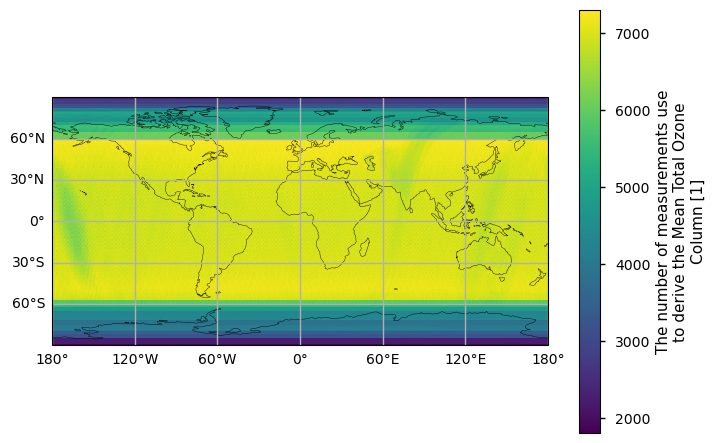

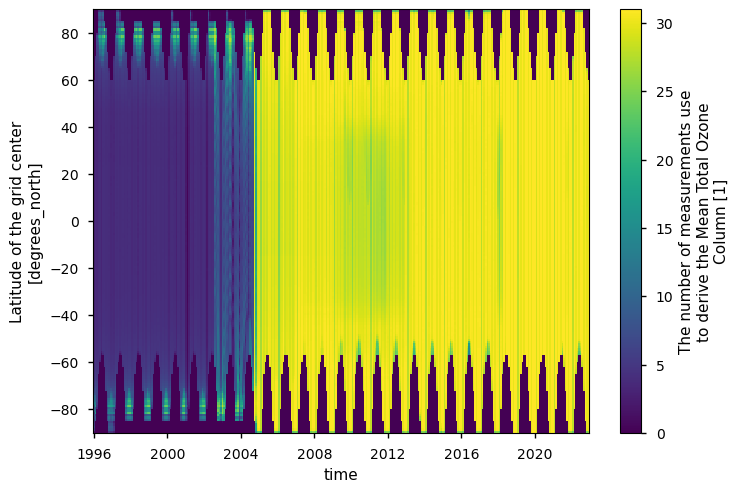

In [6]:
da_obs = ds[f"{varname}_number_of_observations"]
plot.projected_map(da_obs.sum(dim="time", keep_attrs=True), show_stats=False)
plt.show()

with xr.set_options(keep_attrs=True):
    da_sum = da_obs.sum("longitude", keep_attrs=True) / da_obs.sizes["longitude"]
_ = da_sum.plot(x="time")

### Total column ozone distribution and climatology
The global map of total column ozone (TCO) shows that TCO varies strongly with latitude. The highest TCO values are observed at latitudes around 60°S and above 30°N due to the poleward transport of tropical ozone by stratospheric air circulation (Butchart, 2014). As a result, tropical regions become ozone-depleted. Low TCO values are also observed below 60°S, where the Antarctic ozone hole is located (Farman et al., 1985; Bojkov and Filetov, 1995; Solomon et al., 2016).

The contour plot of the climatological monthly TCO means shows that the seasonal variability of ozone levels is small in the tropics and larger above 35° in both hemispheres. Although the dataset is able to reproduce the TCO climatology in the tropics and mid-latitudes, it fails to reproduce the full climatology in polar regions due to the unavailability of data during the polar night from  57.5° poleward in both hemispheres. In particular, the dataset partially captures the TCO depletion typically observed in early autumn and during the austral spring above and below 60° N and S, respectively, but cannot reproduce the low TCO levels typically observed in early austral autumn  (Solomon, 1999; Ross et al., 2023).

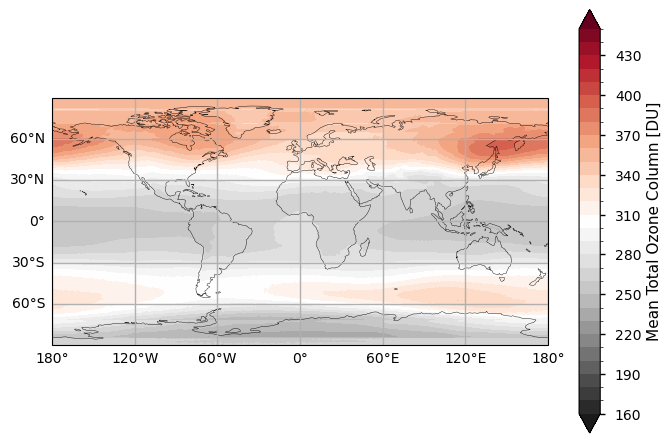

In [7]:

contour_kwargs = {"levels": range(160, 460, 10), "extend": "both", "cmap": "RdGy_r"}
map = plot.projected_map(
    da.mean("time", keep_attrs=True),
    plot_func="contourf",
    show_stats=False,
    **contour_kwargs,
)

## Annual Cycle

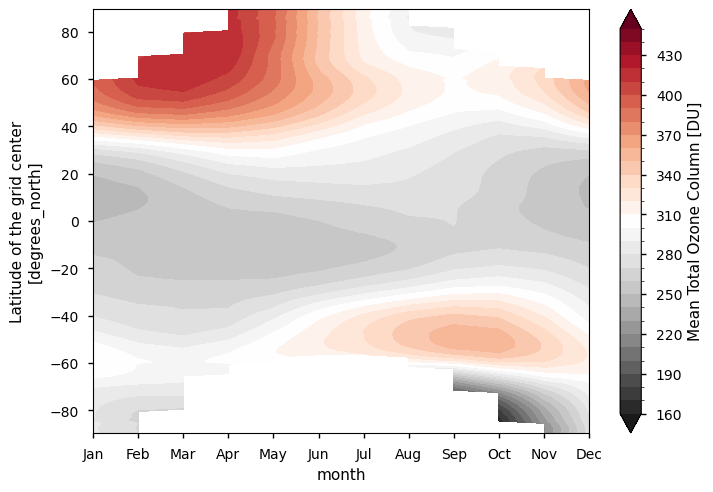

In [8]:
da_annual_cycle = da.groupby("time.month").mean(["time", "longitude"], keep_attrs=True)
da_annual_cycle["month"] = [
    calendar.month_abbr[m] for m in da_annual_cycle["month"].values
]
_ = da_annual_cycle.plot.contourf(x="month", **contour_kwargs)

### Total column ozone time series 
The deseasonalised monthly time series show the limited inter-annual variability at the global scale and over the tropics and mid-latitudes, compared to the larger variability observed over the polar regions. The time series show that the dataset is able to detect documented large variations, such as the large TCO depletion in the Arctic in 2011 and 2020, and the re-emergence of the large, long-lived ozone hole over Antarctica since 2020 due to anomalous circulation patterns (Kessenich et al., 2023; Petkov et al., 2023). Extremely low TCO levels, triggered by the Calbuco eruption, are also observed below 30°S in 2015 (Solomon et al., 2016). In 2010, high TCO levels are observed at mid-latitudes in the Northern Hemisphere due to simulataneous negative phases of the Arctic and North Atlantic Oscillation (Steinbrecht et al., 2011). High TCO levels, induced by the stratospheric warming over Antarctica, are also observed in the southernmost region in 2019 (Saffiedine et al., 2020). Furthermore, the time series show that the dataset is able to reproduce the quasi-biennial oscillation in tropical ozone (Logan et al., 2003).

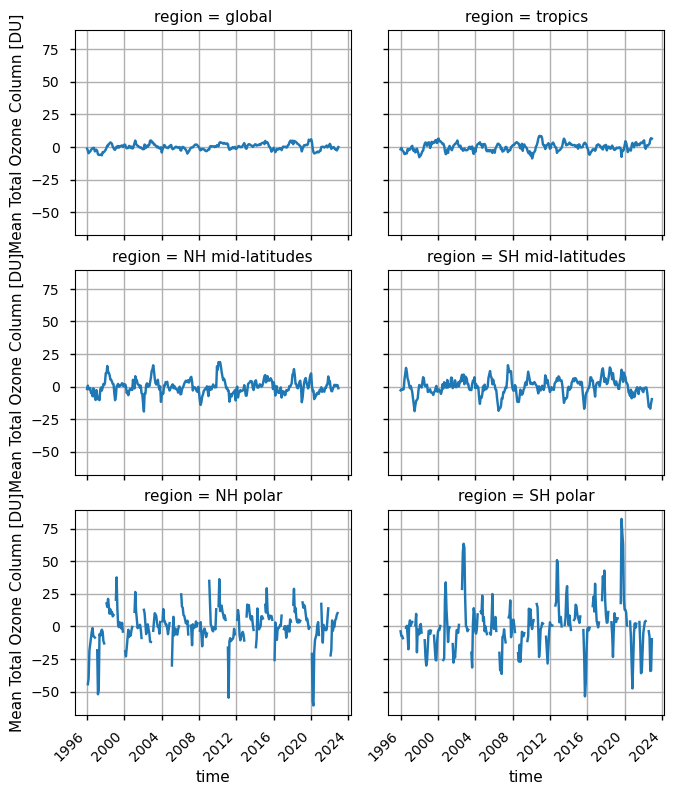

In [9]:
with xr.set_options(keep_attrs=True):
    da_anomaly = (
        ds_timeseries[varname].groupby("time.month")
        - ds_timeseries[varname].groupby("time.month").mean()
    )
    da_anomaly *= da_anomaly.attrs["multiplication_factor_to_convert_to_DU"]
da_anomaly.attrs["units"] = "DU"
facet = da_anomaly.plot(row="region", col_wrap=2)
for ax in facet.axs.flatten():
    ax.grid()
facet.fig.autofmt_xdate(rotation=45)

## References

Boikov, R.D., and Fioletov, V.E. (1995). Estimating the global ozone characteristics during the last 30 years. Journal of Geophysical Research, 100(D8), 16537-16551. https://doi.org/10.1029/95JD00692

Butchart, N. (2014). The Brewer-Dobson circulation. Review of Geophysics, 52(2), 157-184. https://doi.org/10.1002/2013RG000448

Coldewey-Egbers, M., et al. (2015). The GOME-type Total Ozone Essential Climate Variable (GTO-ECV) data record from the ESA Climate Change Initiative, Atmospheric Measurements Techniques, 8, 3923–3940. https://doi.org/10.5194/amt-8-3923-2015.

Farman, J.C., et al. (1985). Large losses of total ozone in Antarctica reveal seasonal ClO$_x$/NO$_x$ interaction. Nature, 315, 207-210. https://doi.org/10.1038/315207a0

Kessenich, H.E., et al. (2023). Potential drivers of the recent large Antarctic ozone holes. Nature Communications, 14, 7259. https://doi.org/10.1038/s41467-023-42637

Logan, J.A., et al. (2003). Quasibiennial oscillation in tropical ozone as revealed by ozonesonde and satellite date. Journal of Geophysical Research, 108, 4244(D8). https://doi.org/10.1029/2002JD002170

Petjov, B.H., et al. (2023. Un Unprecedented Arctic Ozone Depletion Evnet During Spring 2020 and Its Impacts Across Europe. Journal of Geophysical Research: Atmospheres, 128, e2022JD037581. https://doi.org/10.1029/2022JD037581

Ross, J.S., et al. (2023). Twenty Questions and Answers About the Ozone Layer: 2022 Update, Scientific Assessment of Ozone Depletion: 2022, 75 pp., WMO, Geneva, Switzerland.

Safieddine, S., et al. (2020). Antarctic ozone enhancement during the 2019 sudden stratospheric warming event. Geophysical Research Letters,47,e2020GL087810. https://doi.org/10.1029/2020GL087810

Solomon, S. (1999). Stratospheric ozone depletion: A review of concepts and history. Review of Geophysics, 37(3), 275-316. https://doi.org/10.1029/1999RG900008

Solomon, S., et al. (2016). Emergence of healing in the Antarctic ozone layer. Science, 252(6296), 269–274. https://doi.org/10.1126/science.aae0061

Steinbrecht, W., et al. (2011). Very high ozone columns at northern mid-latitudes in 2010. Geophysical research Letters, 38, L06803. https://doi.org/10.1029/2010GL046634

Van Roozendael, M., et al. (2021a). Ozone Product User Guide and Specification (PUGS). Available at: https://datastore.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_PUGS_O3_latest.pdf. Last access: March 27, 2024

Van Roozendael, M., et al. (2021b). Ozone Algorithm Theoretical Basis Document (ATBD). Available at: https://datastore.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_ATBD_O3_latest.pdf. Last access: March 28, 2024